In [1]:
import os
from IPython.display import Image

import pandas as pd
import numpy as np
import itertools
import timeit

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

from sklearn import tree
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Display all columns
pd.set_option('display.max_columns', None)
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV

from collections import Counter
from numpy import where
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from numpy import mean

from sklearn.decomposition import FastICA, PCA
from scipy.stats import kurtosis 
from sklearn import random_projection
from sklearn.decomposition import TruncatedSVD

In [2]:
def load_data(numpy_file_name):
    return np.load(numpy_file_name)


In [3]:
pca_patient = load_data("data/transformed/pca_patient.npy")

In [4]:
pca_insurance = load_data("data/transformed/pca_insurance.npy")

In [5]:
ica_patient = load_data("data/transformed/ica_patient.npy")

In [6]:
ica_insurance = load_data("data/transformed/ica_insurance.npy")

In [10]:
rp_patient = load_data("data/transformed/rp_patient.npy")

In [11]:
rp_insurance = load_data("data/transformed/rp_insurance.npy")

In [12]:
tsvd_patient = load_data("data/transformed/tsvd_patient.npy")

In [46]:
tsvd_insurance = load_data("data/transformed/tsvd_insurance.npy")

In [14]:
from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report


def bench_k_means(kmeans, name, data):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()

    estimator = make_pipeline(kmeans).fit(data)

    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean"
        )
    ]

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

In [18]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture


def calculate_elbow_silhouette_kmeans(data, kmax):
    elbow = []
    silhouette = []
    for k in range(2, kmax+1):
        classifier = KMeans(k).fit(X=data)
        cluster_labels = classifier.fit_predict(X=data)
        elbow.append(classifier.inertia_)
        silhouette.append(silhouette_score(data, cluster_labels, metric = 'euclidean'))
    
    fig = plt.figure(figsize=(15, 5))
    plt.xlabel("Number of clusters")
    plt.ylabel("Inertia")
    plt.xticks(range(2, kmax+1))
    plt.plot(range(2, kmax+1), elbow)
    plt.grid(True)
    plt.title('Elbow curve')
    
    fig = plt.figure(figsize=(15, 5))
    plt.xlabel("Number of clusters")
    plt.ylabel("Silhouette score")
    plt.xticks(range(2, kmax+1))
    plt.plot(range(2, kmax+1), silhouette)
    plt.grid(True)
    plt.title('Silhouette curve')
    
    return elbow, silhouette


def calculate_silhouette_gaussian(data, kmax):
    silhouette = []
    for k in range(2, kmax+1):
        classifier = GaussianMixture(k).fit(X=data)
        cluster_labels = classifier.fit_predict(X=data)
        silhouette.append(silhouette_score(data, cluster_labels, metric = 'euclidean', sample_size=10000))
    
    fig = plt.figure(figsize=(15, 5))
    plt.xlabel("Number of clusters")
    plt.ylabel("Silhouette score")
    plt.xticks(range(2, kmax+1))
    plt.plot(range(2, kmax+1), silhouette)
    plt.grid(True)
    plt.title('Silhouette curve')
    
    return silhouette


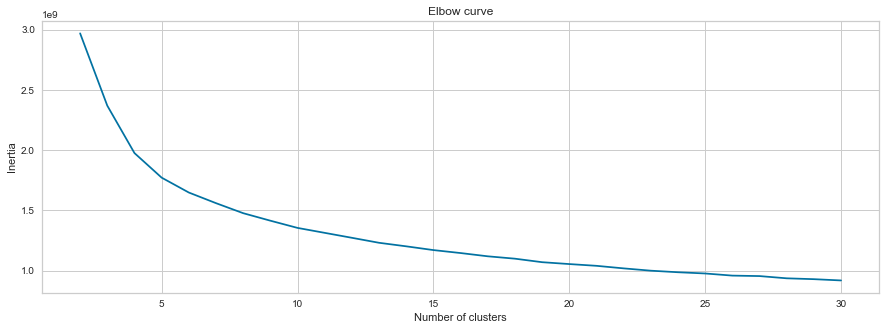

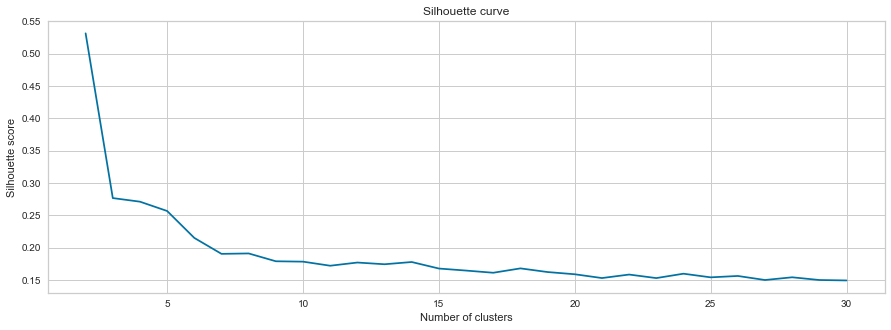

In [240]:
sse_patient, silhouette_patient = calculate_elbow_silhouette_kmeans(patient_X_train, patient_y_train, 30)

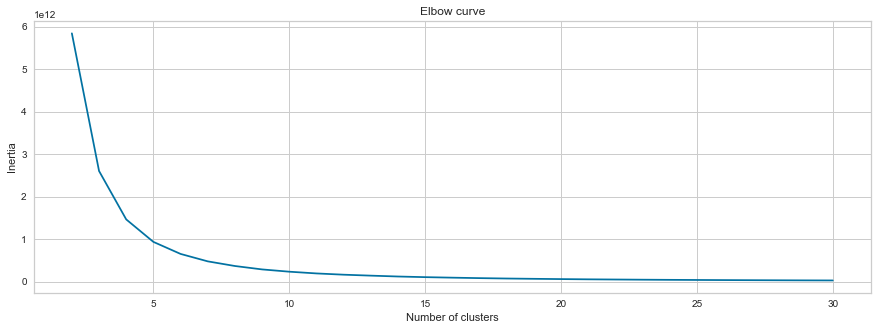

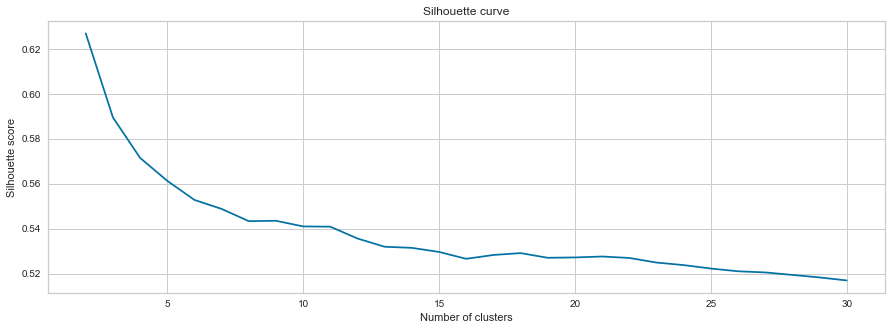

In [241]:
sse_insurance, silhouette_insurance = calculate_elbow_silhouette_kmeans(insurance_X_train, insurance_y_train, 30)

### Kmeans + PCA

In [15]:
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

print(82 * "_")
print("init\t\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

kmeans = KMeans(init="k-means++", n_clusters=42, n_init=4, random_state=10)
bench_k_means(kmeans=kmeans, name="k-means++ PCA Patient", data=pca_patient)

kmeans = KMeans(init="random", n_clusters=42, n_init=4, random_state=10)
bench_k_means(kmeans=kmeans, name="random PCA Patient", data=pca_patient)

# kmeans = KMeans(init="k-means++", n_clusters=2, n_init=4, random_state=10)
# bench_k_means(kmeans=kmeans, name="k-means++ Insurance", data=insurance_X_train, labels=insurance_y_train)

# kmeans = KMeans(init="random", n_clusters=2, n_init=4, random_state=10)
# bench_k_means(kmeans=kmeans, name="random Insurance", data=insurance_X_train, labels=insurance_y_train)

# pca = PCA(n_components=4).fit(patient_X_train)
# kmeans = KMeans(init=pca.components_, n_clusters=4, n_init=4, random_state=10)
# bench_k_means(kmeans=kmeans, name="PCA-based Patient", data=patient_X_train, labels=patient_y_train)

# pca = PCA(n_components=4).fit(insurance_X_train)
# kmeans = KMeans(init=pca.components_, n_clusters=4, n_init=4, random_state=10)
# bench_k_means(kmeans=kmeans, name="PCA-based Insurance", data=insurance_X_train, labels=insurance_y_train)


__________________________________________________________________________________
init			time	inertia	homo	compl	v-meas	ARI	AMI	silhouette


NameError: name 'labels' is not defined

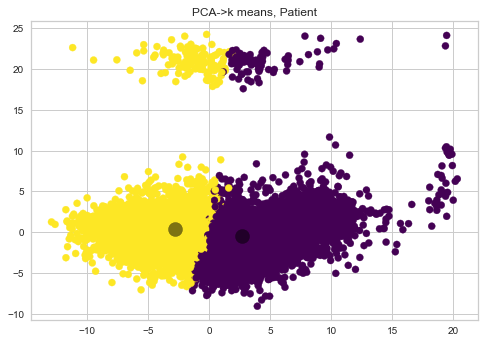

In [49]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2)
kmeans.fit(pca_patient)
y_kmeans = kmeans.predict(pca_patient)

plt.scatter(pca_patient[:, 0], pca_patient[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.title("PCA->k means, Patient")
plt.show()

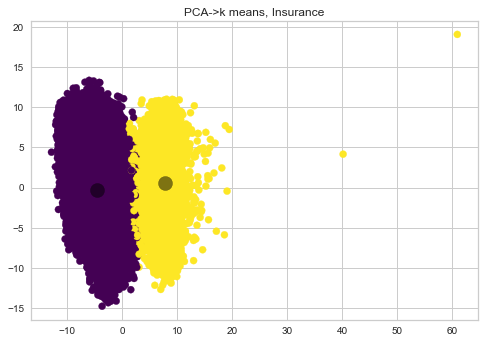

In [50]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(pca_insurance)
y_kmeans = kmeans.predict(pca_insurance)
plt.scatter(pca_insurance[:, 0], pca_insurance[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.title("PCA->k means, Insurance")
plt.show()

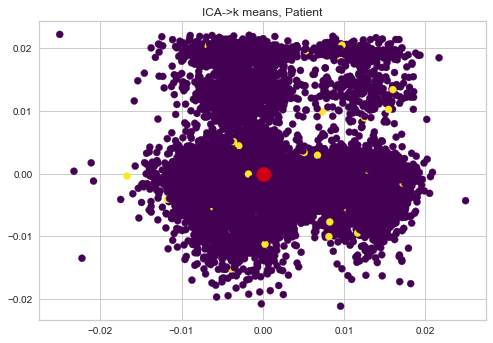

In [54]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(ica_patient)
y_kmeans = kmeans.predict(ica_patient)

plt.scatter(ica_patient[:, 0], ica_patient[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5);
plt.title("ICA->k means, Patient")
plt.show()

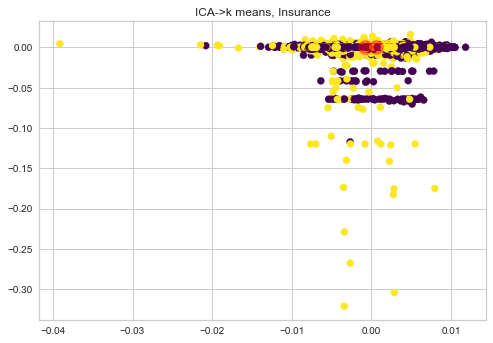

In [55]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(ica_insurance)
y_kmeans = kmeans.predict(ica_insurance)

plt.scatter(ica_insurance[:, 0], ica_insurance[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5);
plt.title("ICA->k means, Insurance")
plt.show()

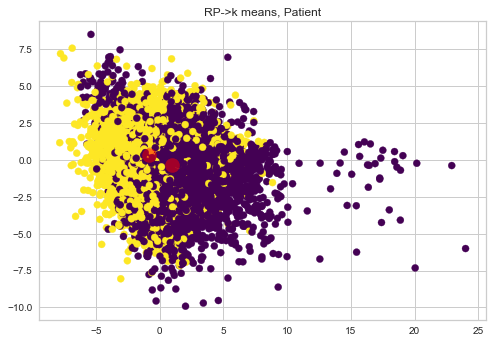

In [58]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(rp_patient)
y_kmeans = kmeans.predict(rp_patient)

plt.scatter(rp_patient[:, 0], rp_patient[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5);
plt.title("RP->k means, Patient")
plt.show()

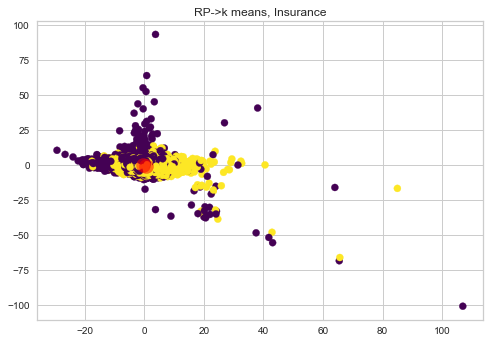

In [61]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(rp_insurance)
y_kmeans = kmeans.predict(rp_insurance)

plt.scatter(rp_insurance[:, 0], rp_insurance[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5);
plt.title("RP->k means, Insurance")
plt.show()

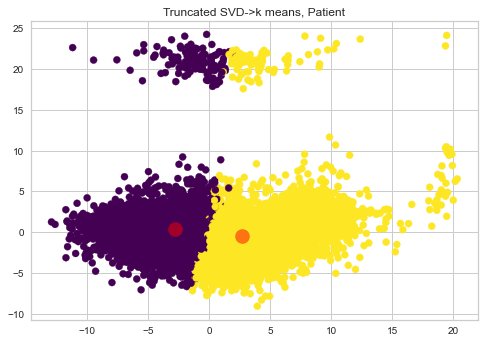

In [63]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(tsvd_patient)
y_kmeans = kmeans.predict(tsvd_patient)

plt.scatter(tsvd_patient[:, 0], tsvd_patient[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5);
plt.title("Truncated SVD->k means, Patient")
plt.show()

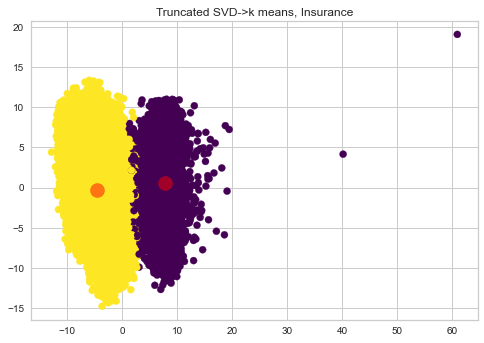

In [64]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(tsvd_insurance)
y_kmeans = kmeans.predict(tsvd_insurance)

plt.scatter(tsvd_insurance[:, 0], tsvd_insurance[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5);
plt.title("Truncated SVD->k means, Insurance")
plt.show()

In [37]:
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import InterclusterDistance
from yellowbrick.cluster import KElbowVisualizer

def generate_kmeans_SV_ICD_plots(X, k):
    plot_nums = len(k)
    fig, axes = plt.subplots(plot_nums, 2, figsize=[25, 40])
    col_ = 0
    for i in k:
        kmeans = KMeans(n_clusters=i, algorithm="full")
        visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=axes[col_][0])
        visualizer.fit(X)
        visualizer.finalize()
        
        kmeans = KMeans(n_clusters=i, algorithm="full")
        visualizer = InterclusterDistance(kmeans, ax=axes[col_][1])
        visualizer.fit(X)
        visualizer.finalize()
        
        col_+=1
    plt.show()


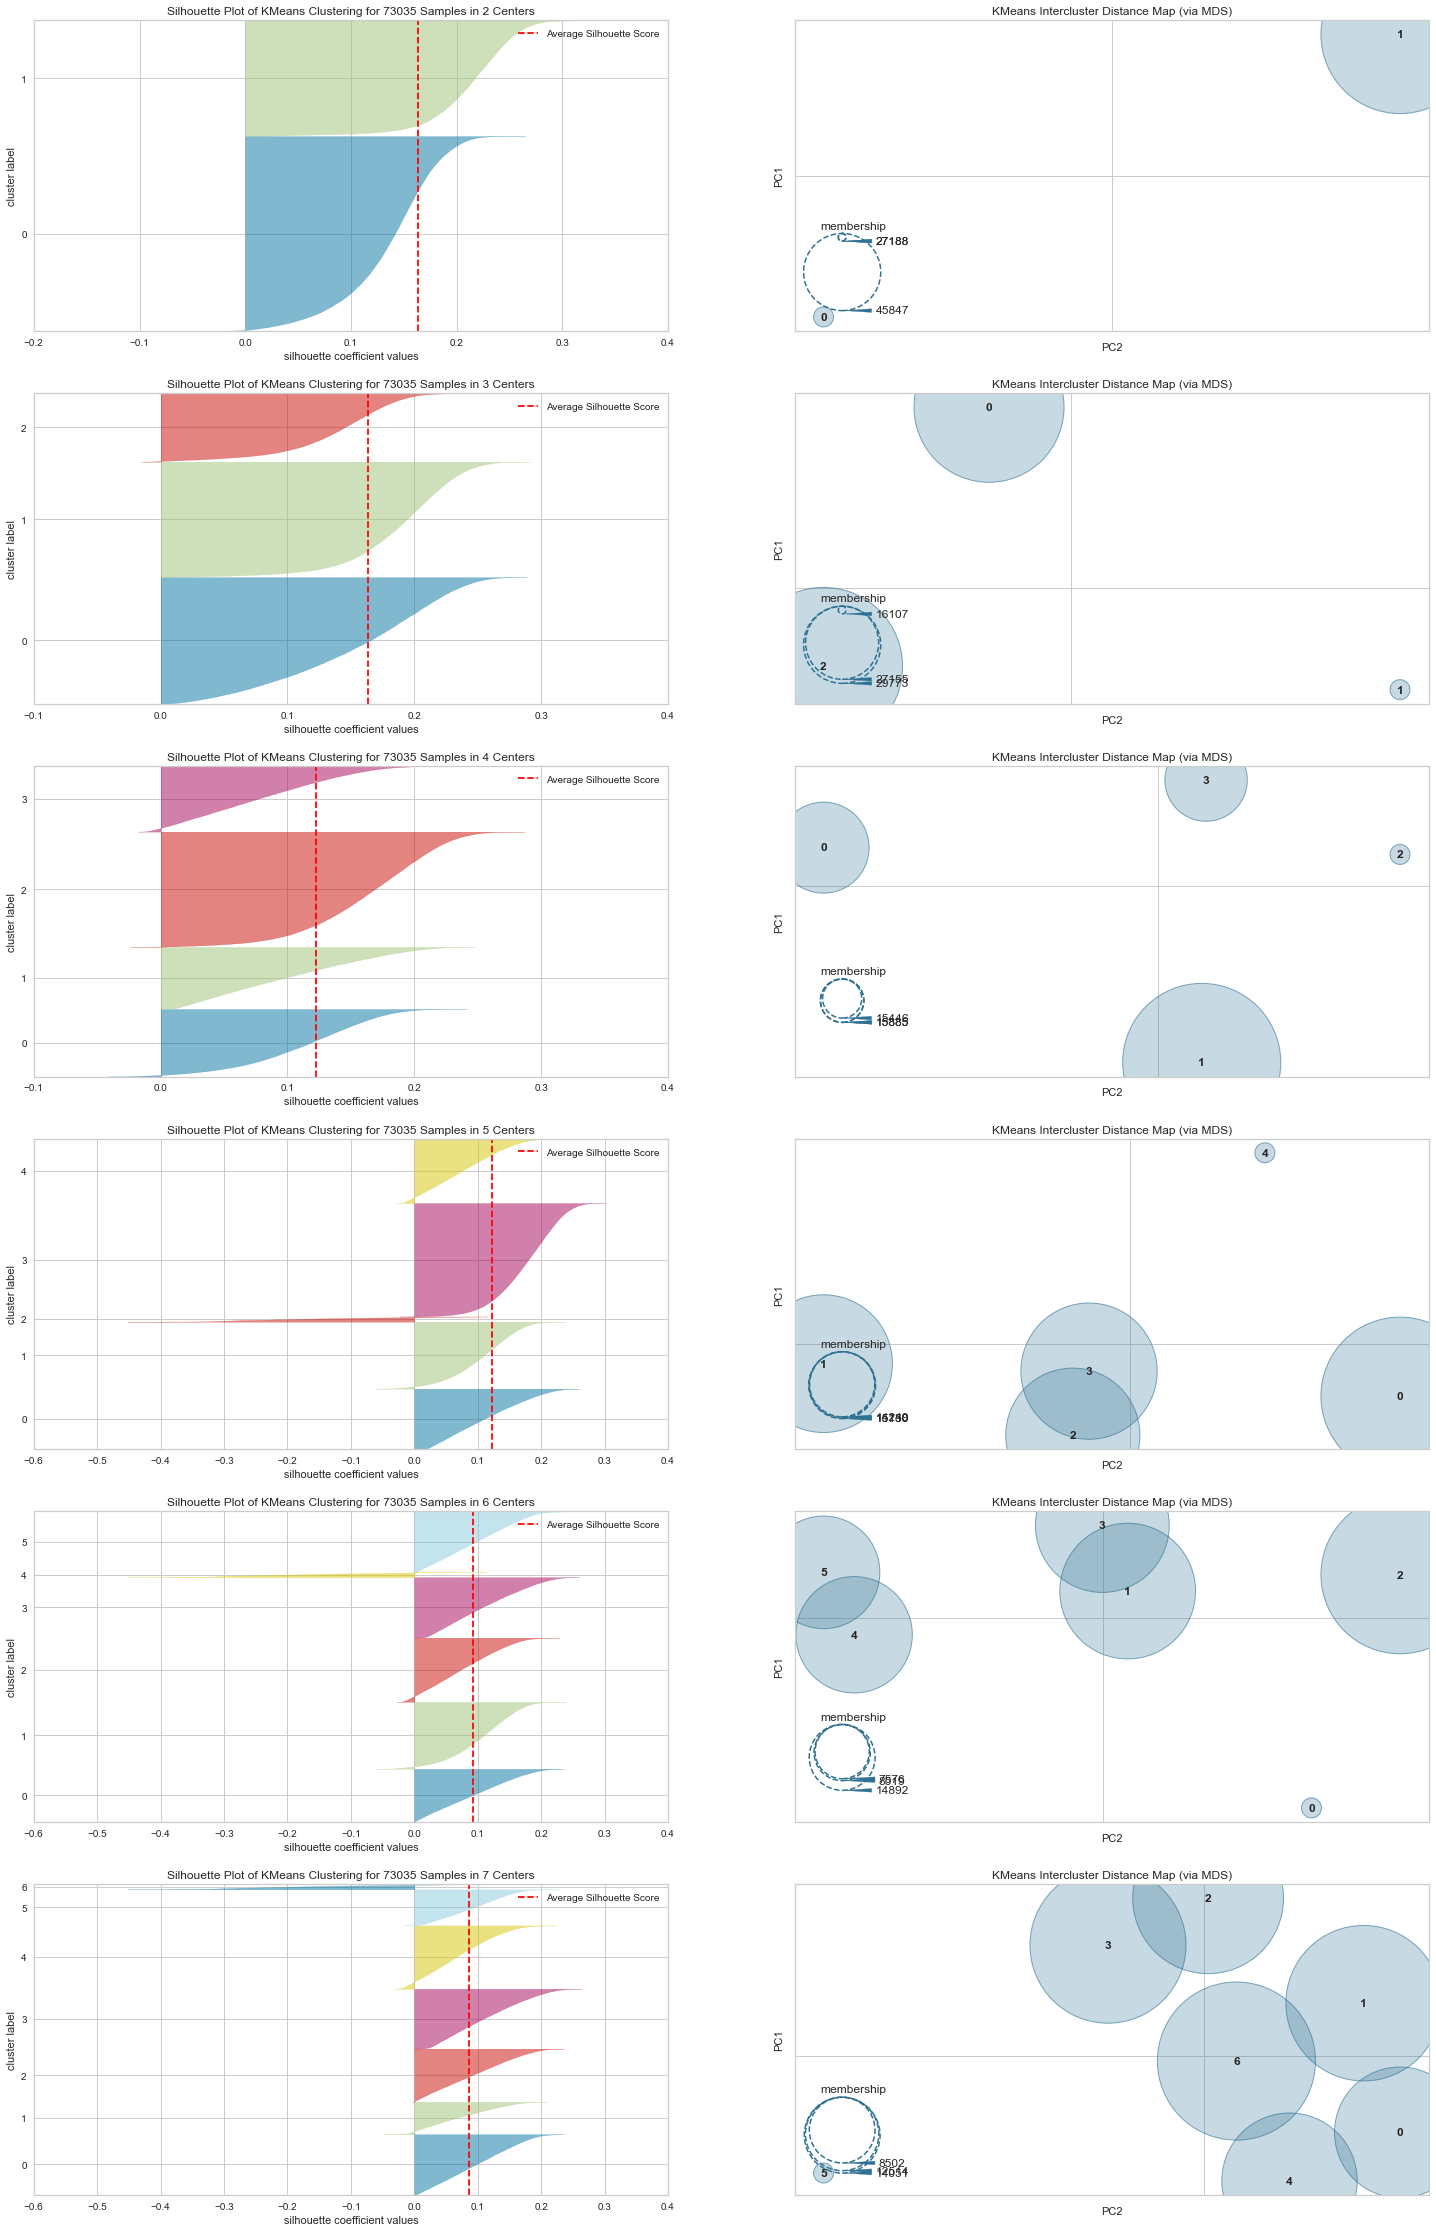

In [38]:
k = list(range(2,8))
generate_kmeans_SV_ICD_plots(pca_insurance, k)


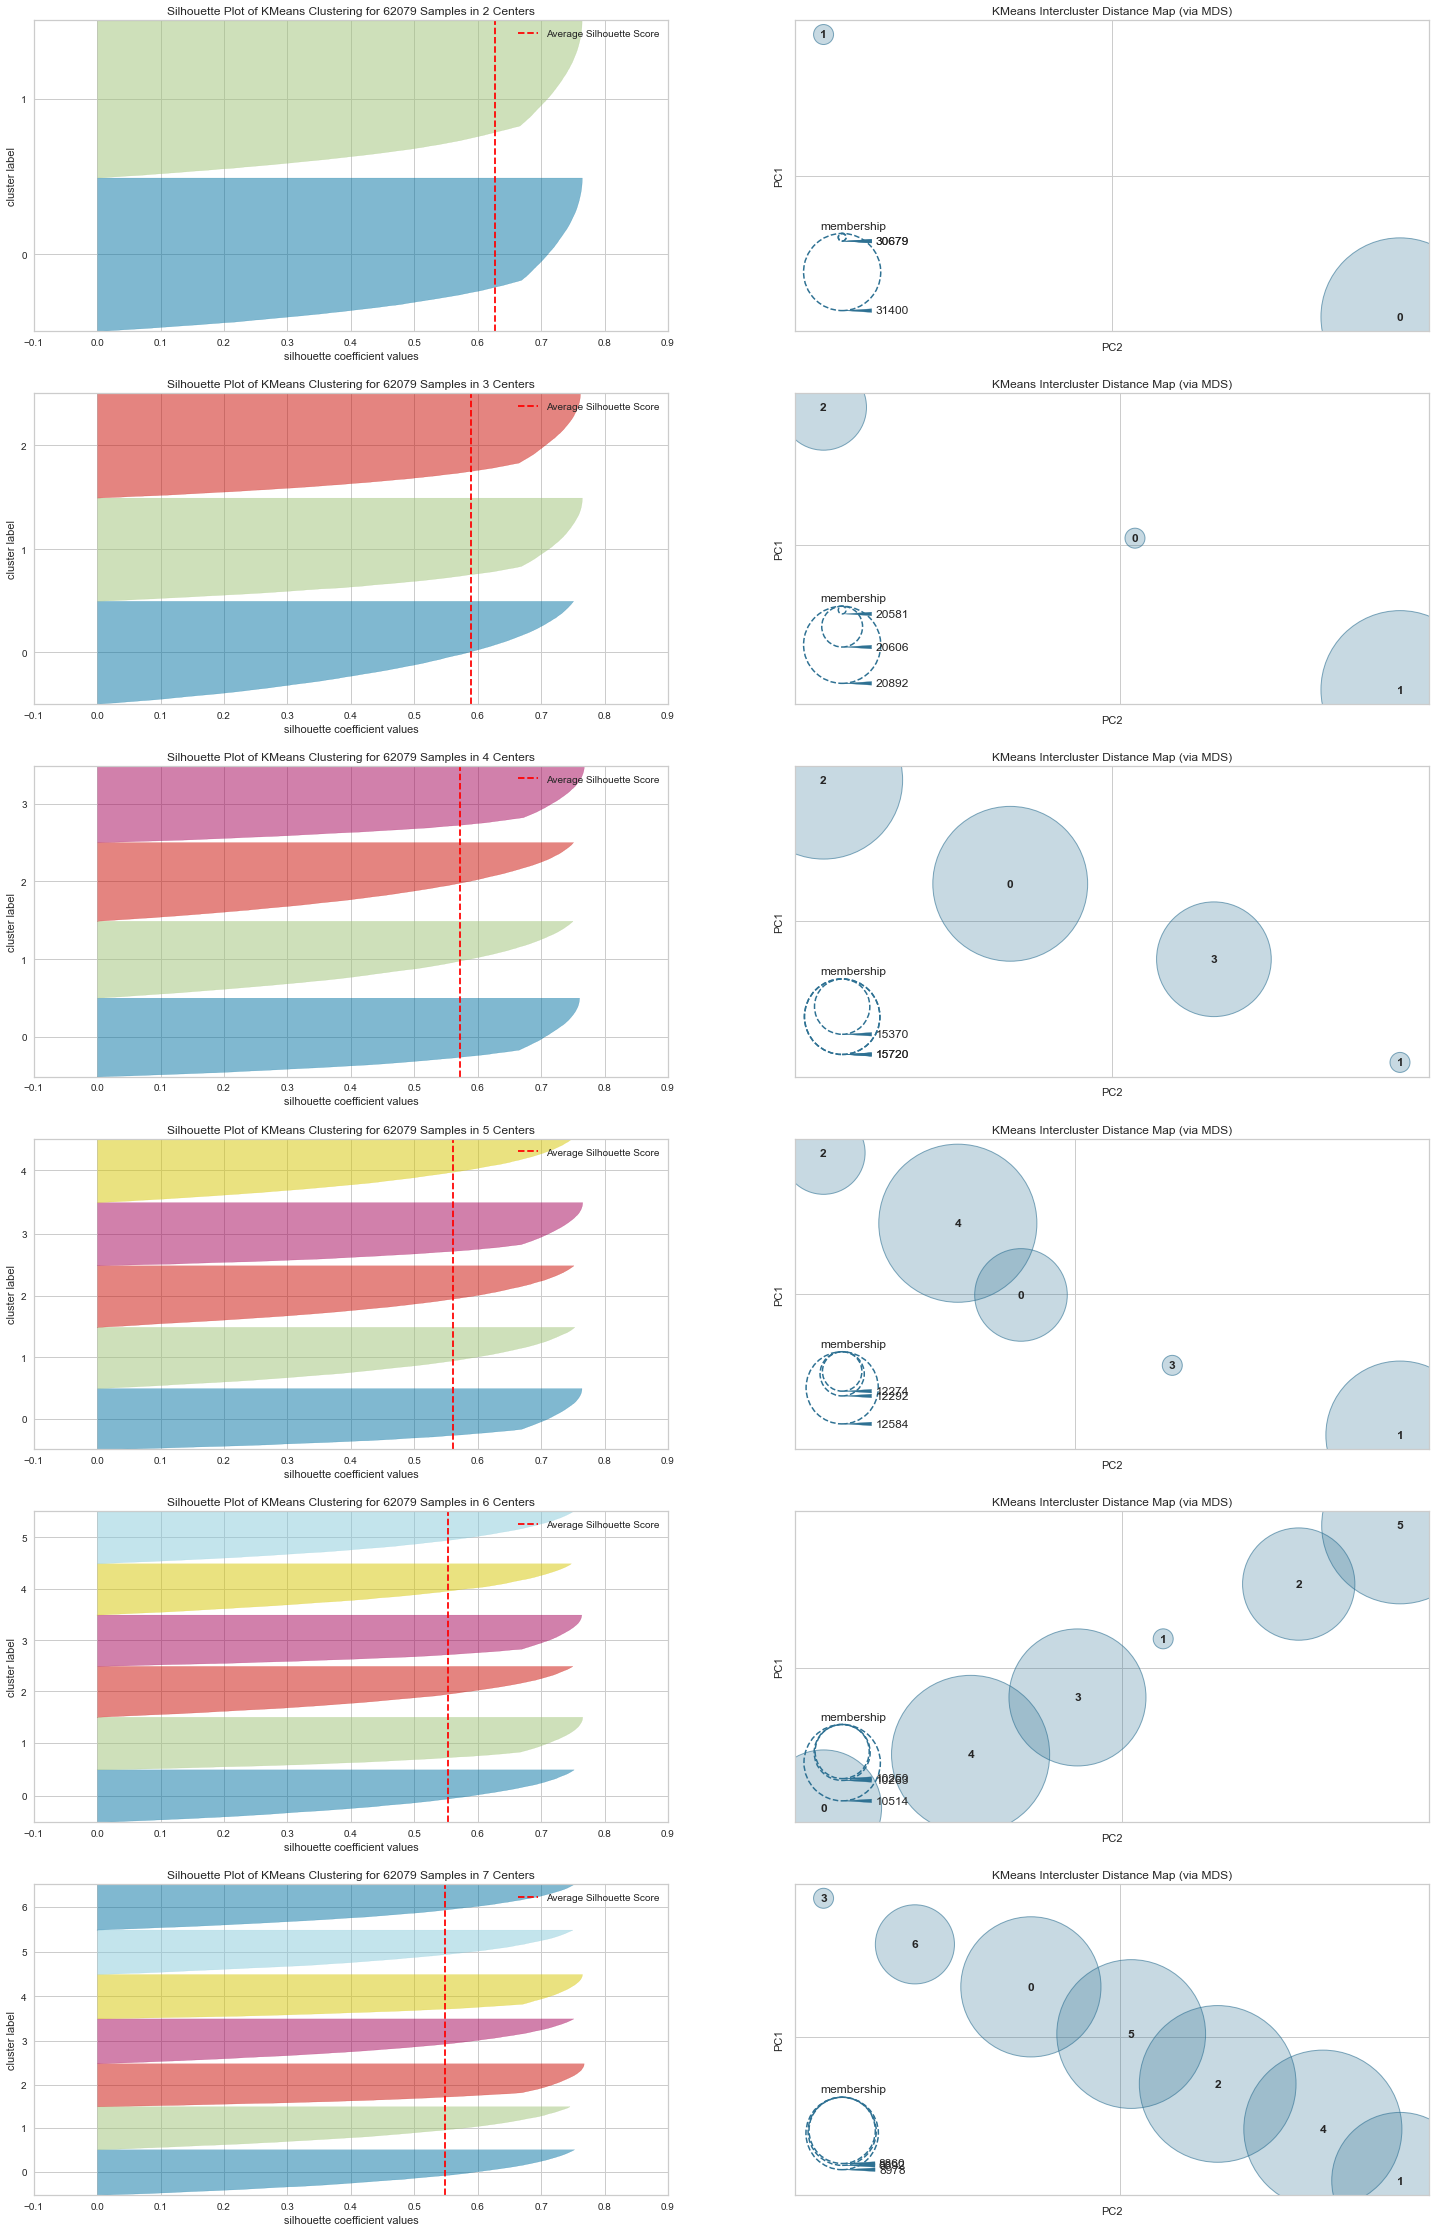

In [239]:
k = list(range(2,8))
generate_kmeans_SV_ICD_plots(insurance_X_train, k)


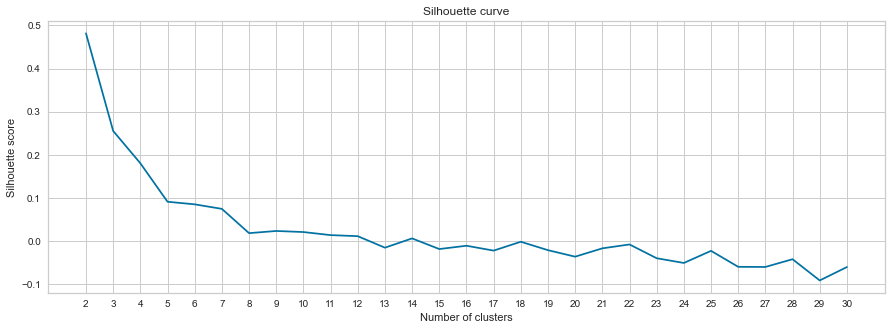

In [256]:
silhouette_patient_gm = calculate_silhouette_gaussian(patient_X_train, kmax=20)

In [ ]:
silhouette_insurance_gm = calculate_silhouette_gaussian(insurance_X_train, kmax=15)

In [42]:
def select_shorted_config(arr:list, X:int)->list:
    '''
    returns the set of X configurations with shorter distance
    '''
    dx=np.argsort(arr)[:X]
    return arr[dx]

def gmm_js(gmm_p, gmm_q, n_samples=10000):
    
    X = gmm_p.sample(n_samples)[0]
    log_p_X = gmm_p.score_samples(X)
    log_q_X = gmm_q.score_samples(X)
    log_mix_X = np.logaddexp(log_p_X, log_q_X)

    Y = gmm_q.sample(n_samples)[0]
    log_p_Y = gmm_p.score_samples(Y)
    log_q_Y = gmm_q.score_samples(Y)
    log_mix_Y = np.logaddexp(log_p_Y, log_q_Y)

    return np.sqrt((log_p_X.mean() - (log_mix_X.mean() - np.log(2))
            + log_q_Y.mean() - (log_mix_Y.mean() - np.log(2))) / 2)


def generate_distance_bw_gmms_plots(data, n):
    
    n_clusters=np.arange(2, n)
    iterations=n
    distances=[]
    distances_std=[]
    for n in n_clusters:
        dist=[]

        for iteration in range(iterations):
            train, test=train_test_split(data, test_size=0.5)

            gmm_train=GaussianMixture(n, n_init=2).fit(train) 
            gmm_test=GaussianMixture(n, n_init=2).fit(test) 
            dist.append(gmm_js(gmm_train, gmm_test))
            
        shorted_config=select_shorted_config(np.array(dist), int(iterations/5))
        
        result=np.mean(shorted_config)
        distance_std=np.std(shorted_config)

        distances.append(result)
        distances_std.append(distance_std)


    plt.errorbar(n_clusters, distances, yerr=distances_std)
    plt.title("Distance between Train and Test GMMs", fontsize=20)
    plt.xticks(n_clusters)
    plt.xlabel("Number of components")
    plt.ylabel("Distance")
    plt.show()


In [45]:
def generate_bic_plot(X, n):
    n_clusters=np.arange(2, n)
    bics=[]
    bics_err=[]
    iterations=n
    for n in n_clusters:
        tmp_bic=[]
        for _ in range(iterations):
            gmm=GaussianMixture(n, n_init=2).fit(X) 

            tmp_bic.append(gmm.bic(X))
        val=np.mean(select_shorted_config(np.array(tmp_bic), int(iterations/5)))
        err=np.std(tmp_bic)
        bics.append(val)
        bics_err.append(err)

    plt.errorbar(n_clusters,bics, yerr=bics_err, label='BIC')
    plt.title("BIC Scores", fontsize=20)
    plt.xticks(n_clusters)
    plt.xlabel("Number of components")
    plt.ylabel("Score")
    plt.legend()
    plt.show()
    plt.clf()
    
    plt.errorbar(n_clusters, np.gradient(bics), yerr=bics_err, label='BIC')
    plt.title("Gradient of BIC Scores", fontsize=20)
    plt.xticks(n_clusters)
    plt.xlabel("Number of components")
    plt.ylabel("gradient(BIC)")
    plt.legend()
    plt.show()
    plt.clf()


In [ ]:
generate_bic_plot(patient_X, 10)

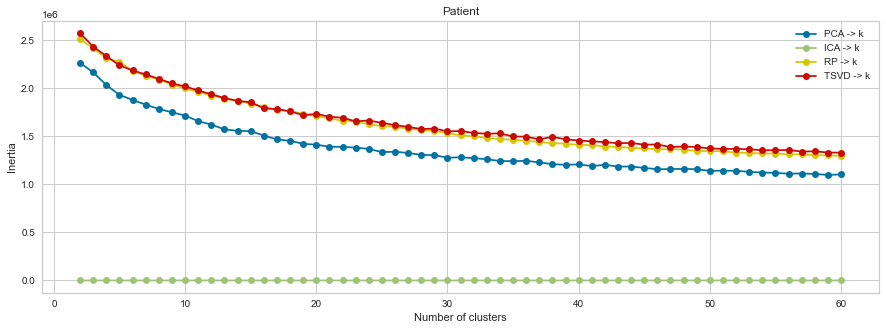

In [44]:
# algo_k = [
#     (pca_patient, 42, "PCA -> k", "b"),
#     (ica_patient, 59, "ICA -> k", "g"),
#     (rp_patient, 38, "RP -> k", "y"),
#     (tsvd_patient, 57, "TSVD -> k", "r"), 
# ]

algo_k = [
    (pca_patient, "PCA -> k", "b"),
    (ica_patient, "ICA -> k", "g"),
    (rp_patient, "RP -> k", "y"),
    (tsvd_patient, "TSVD -> k", "r"), 
]


fig = plt.figure(figsize=(15, 5))
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.grid(True)

for data, label, color in algo_k:
    elbow = []
    for k in range(2, 61):
        classifier = KMeans(k).fit(X=data)
        cluster_labels = classifier.fit_predict(X=data)
        elbow.append(classifier.inertia_)
    plt.plot(range(2, 61), elbow, 'o-', color=color, label=label)

plt.legend(loc="best")
# plt.xticks(range(2, kmax+1))
# plt.plot(range(2, kmax+1), elbow)
plt.title('Patient')
plt.show()

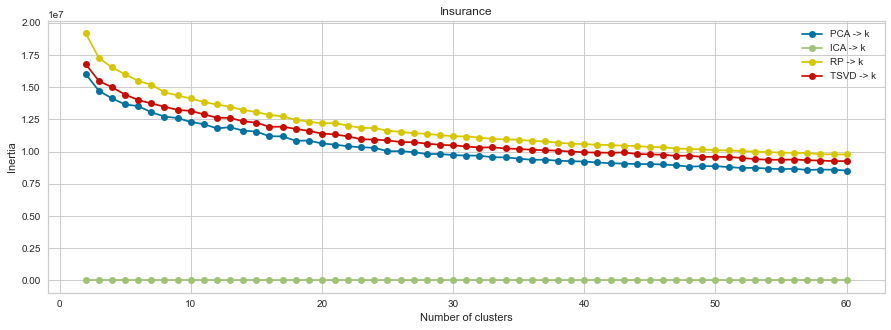

In [47]:
algo_k = [
    (pca_insurance, "PCA -> k", "b"),
    (ica_insurance, "ICA -> k", "g"),
    (rp_insurance, "RP -> k", "y"),
    (tsvd_insurance, "TSVD -> k", "r"), 
]


fig = plt.figure(figsize=(15, 5))
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.grid(True)

for data, label, color in algo_k:
    elbow = []
    for k in range(2, 61):
        classifier = KMeans(k).fit(X=data)
        cluster_labels = classifier.fit_predict(X=data)
        elbow.append(classifier.inertia_)
    plt.plot(range(2, 61), elbow, 'o-', color=color, label=label)

plt.legend(loc="best")
# plt.xticks(range(2, kmax+1))
# plt.plot(range(2, kmax+1), elbow)
plt.title('Insurance')
plt.show()